In [126]:
%matplotlib inline
import pandas as pd
import os
import gc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
def memory_usage(df, name):
    mb = df.memory_usage().sum() / 1024 / 1024
    print(name + ' use {:.2f} mb in memory'.format(mb))

# Загрузка данных

In [2]:
data_path = './data'
#data_path = '/kaggle/input'
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        current_file_path = os.path.join(dirname, filename)
        if 'lectures.csv' in current_file_path:
            lectures_path = current_file_path
        if 'questions.csv' in current_file_path:
            questions_path = current_file_path
        if 'train.csv' in current_file_path:
            data_path = current_file_path
        print(current_file_path)

./data/.DS_Store
./data/riiid-test-answer-prediction/lectures.csv
./data/riiid-test-answer-prediction/example_sample_submission.csv
./data/riiid-test-answer-prediction/questions.csv
./data/riiid-test-answer-prediction/train.csv
./data/riiid-test-answer-prediction/example_test.csv
./data/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
./data/riiid-test-answer-prediction/riiideducation/__init__.py


In [149]:
lectures_df = pd.read_csv(lectures_path)
questions_df = pd.read_csv(questions_path)
data = pd.read_csv(data_path, low_memory=False, nrows=1e6, 
                   dtype={'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 
                          'content_id': 'int16', 'content_type_id': 'int8', 'task_container_id': 'int16', 
                          'user_answer': 'int8', 'answered_correctly': 'int8', 
                          'prior_question_elapsed_time': 'float32', 
                          'prior_question_had_explanation': 'boolean'
                         }
                  )

In [197]:
df = pd.read_csv('./data/riiid-test-answer-prediction/example_test.csv')

<AxesSubplot:>

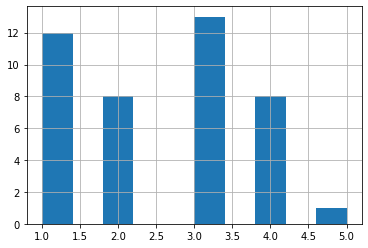

In [201]:
df['prior_question_elapsed_time'].isnull().sum()

1

# Описание данных

## train.csv

* `row_id` -- Номер строки
* `timestamp` -- Время (милисекунды) между началом взаимодействия и временем завершения
* `user_id` -- id пользователя
* `content_id` -- ключ для questions.csv
* `content_type_id` -- 0 - вопрос, 1 - просмотр лекции
* `task_container_id` -- id пачки вопросов (до объяснения ответов)
* `user_answer` -- ответ пользователя (-1 в случае лекции)
* `answered_correctly` -- 1 - ответ правильный, 0 - ответ неправильный (-1 в случае лекции)
* `prior_question_elapsed_time` -- среднее время (милисекунды) затраченное пользователем на каждый вопрос из пычки предыдущих вопросов (лекции не считаются. 0 для первой пачки вопросов)
* `prior_question_had_explanation` -- видел ли пользователь объяснения на предыдущий пакет вопросов. (0 для первого пакета. В первом пакете пользователь обычно получает вопросы обобщённого характера без обратной связи)


In [40]:
data.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


## questions.csv

* `question_id` -- внешний ключ для data.content_id в случае `content_type_id` == 0
* `bundle_id` -- код вопросов, подающихся вместе. Для комбинации user_id-bundle_id присваиваются уникальные значения временных характеристик.
* `correct_answer` -- правильный ответ на вопрос (можно сверить с колонкой корректного ответа в data)
* `part` -- раздел [теста](https://www.iibc-global.org/english/toeic/test/lr/about/format.html). 1-4 -- listening, 5-7 -- reading
* `tags` -- теги вопросов через пробел. Можно использовать для кластеризации вопросов.

In [21]:
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


## lectures.csv

* `lecture_id` -- внешний ключ для data.content_id в случае `content_type_id` == 1
* `tag` -- тег (единственный) лекции. Можно использовать для кластеризации лекций.
* `part` -- раздел лекции. Их также 7 штук, похоже, что согласуются с разделами теста.
* `type_of` -- короткое описание цели лекции

In [24]:
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [18]:
lectures_df.type_of.unique()

array(['concept', 'solving question', 'intention', 'starter'],
      dtype=object)

# Исследование данных

## merged_df

In [172]:
def merge_data(data, questions_df, lectures_df, drop_lectures=):
    # Собираем общий массив
    questions_df.columns = ['content_id', 'bundle_id', 'correct_answer', 'part', 'tags']
    lectures_df.columns = ['content_id', 'lecture_tag', 'lecture_part', 'type_of_lecture']
    full_df = data.merge(questions_df, on='content_id', how='left').merge(lectures_df, on='content_id', how='left')
    # Уменьшаем размер массива путём объединения колонок и заполенения наллов
    full_df.loc[full_df['part'].isnull(), 'part'] = full_df.loc[full_df['part'].isnull(), 'lecture_part']
    full_df.loc[full_df['tags'].isnull(), 'tags'] = full_df.loc[full_df['tags'].isnull(), 'lecture_tag'].astype(str)
    full_df.drop(columns=['lecture_part', 'lecture_tag'], inplace=True)
    full_df.loc[full_df['correct_answer'].isnull(), 'correct_answer'] = -1
    full_df['correct_answer'] = full_df['correct_answer'].astype('int8')
    full_df['part'] = full_df['part'].astype('int8')
    # Ищем статистики для заполнения
    full_df.loc[:, 'prior_question_elapsed_time'] = full_df.loc[:, 'prior_question_elapsed_time'].astype('float64')
    users_stats = (
        full_df[full_df['answered_correctly']!=-1].
        groupby('user_id').
        agg({'prior_question_elapsed_time': ['sum', 'count', 'mean']}).
        reset_index()
    )
    users_stats.columns = ['user_id', 'question_elapsed_time_sum', 'answers_count', 'question_elapsed_time_mean']
    full_df = full_df.merge(users_stats, on='user_id', how='left')
    # Заполняем наллы первых ответов
    index_nulls = full_df.prior_question_elapsed_time.isnull()
    full_df.loc[index_nulls, 'prior_question_elapsed_time'] = full_df.loc[index_nulls, 'question_elapsed_time_mean']
    full_df.loc[index_nulls, 'prior_question_had_explanation'] = False
    # Убеждаемся в правильности ответов
    full_df['answered_correctly_really'] = (full_df['user_answer'] == full_df['correct_answer']).astype('int8')
    index_dev = (
        (full_df['answered_correctly_really'] != full_df['answered_correctly']) 
        & (full_df['answered_correctly'] != -1)
    )
    deviations_count = index_dev.sum()
    if deviations_count > 0:
        print('Wrong answer_correctly in {} rows'.format(deviations_count))
        full_df.loc[index_dev, 'answered_correctly'] = full_df.loc[index_dev, 'answered_correctly_really']
    full_df.drop(columns=['answered_correctly_really', 'correct_answer'], inplace=True)
    memory_usage(full_df, 'merged_df')
    return full_df

In [182]:
full_df = merge_data(data, questions_df, lectures_df)

merged_df use 89.65 mb in memory


In [153]:
full_df.dtypes

row_id                               int64
timestamp                            int64
user_id                              int32
content_id                           int16
content_type_id                       int8
task_container_id                    int16
user_answer                           int8
answered_correctly                    int8
prior_question_elapsed_time        float64
prior_question_had_explanation     boolean
bundle_id                          float64
part                                  int8
tags                                object
type_of_lecture                     object
prior_question_elapsed_time_sum    float64
answers_count                        int64
dtype: object

In [154]:
full_df.head(2)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,part,tags,type_of_lecture,prior_question_elapsed_time_sum,answers_count
0,0,0,115,5692,0,1,3,1,19933.311111,False,5692.0,5,151,NaN,896999.0,45
1,1,56943,115,5716,0,2,2,1,37000.000000,False,5716.0,5,168,NaN,896999.0,45


# Features engineereing

**Данных по лекциям очень мало, пока выкинем их из рассмотрения**

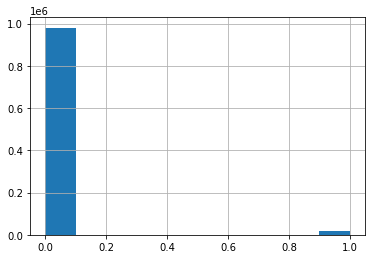

In [169]:
full_df['content_type_id'].hist();

In [170]:
full_df = full_df.loc[full_df['content_type_id'] == 0, :]
full_df.drop(columns='type_of_lecture', inplace=True)

**Посчитаем время, затраченное на текущий ответ**

In [183]:
# Время, затраченное на ответ (у пачки вопросоd временные характеристики одинаковые)
bundles = full_df[['timestamp', 'user_id', 'bundle_id', 'prior_question_elapsed_time', 
                    'question_elapsed_time_mean']].drop_duplicates()
bundles['question_elapsed_time'] = (
    bundles
    .sort_values(by=['timestamp'], ascending=True)
    .groupby(['user_id'])['prior_question_elapsed_time'].shift(-1)
    .dropna()
)
# Заменяем последние значения средним временем ответа пользоваетля на вопрос
index_nulls = boundles.question_elapsed_time.isnull()
bundles.loc[index_nulls, 'question_elapsed_time'] = bundles.loc[index_nulls, 'question_elapsed_time_mean']
# Добавляем данные к итоговому массиву
full_df = full_df.merge(bundles[['timestamp', 'user_id', 'bundle_id', 'question_elapsed_time']], 
                        on=['user_id', 'bundle_id', 'timestamp'],
                        how='left')

**Характеристики вопросов**

In [190]:
# Характеристики правильности ответов
questions_characteristics = (
    full_df.groupby(['content_id', 'bundle_id']).
    agg({'answered_correctly': ['sum', 'count']}).
    reset_index()
)
questions_characteristics.columns = ['content_id', 'bundle_id', 'answered_correctly_sum', 'answers_count']
# Время, затраченное на ответ
bundles = (
    full_df.groupby('bundle_id').
    agg({'question_elapsed_time': ['sum', 'count', 'mean']}).
    reset_index()
)
bundles.columns = ['bundle_id', 'answer_bundle_time_sum', 'bundle_count', 'answer_bundle_time_mean']
# Итоговый массив харастеристик вопросов
questions_characteristics = questions_characteristics.merge(bundles, on='bundle_id', how='left')
questions_characteristics.head(2)

,content_id,bundle_id,answered_correctly_sum,answers_count,answer_bundle_time_sum,bundle_count,answer_bundle_time_mean
0,0,0.0,63.0,73,1.335988e+06,73,18301.198819
1,1,1.0,51.0,55,1.347000e+06,55,24490.909091


**Характеристики пользователей**

In [193]:
# Характеристики правильности ответов
users_characteristics = (
    full_df.groupby(['user_id']).
    agg({'answered_correctly': ['sum', 'count']}).
    reset_index()
)
users_characteristics.columns = ['user_id', 'answered_correctly_sum', 'answers_count']
# Время, затраченное на ответ
users_characteristics = (
    full_df[['user_id', 'question_elapsed_time_sum', 'question_elapsed_time_mean']].drop_duplicates()
    .merge(users_characteristics, on='user_id', how='left')
)
users_characteristics.head(3)

,user_id,question_elapsed_time_sum,question_elapsed_time_mean,answered_correctly_sum,answers_count
0,115,896999.0,19933.311111,32.0,46
1,124,544997.0,18793.000000,7.0,30
2,2746,325000.0,18055.555556,10.0,20


## questions clusterization

In [95]:
from sklearn.preprocessing import OneHotEncoder

In [133]:
df = questions_df.assign(tags=questions_df.tags.str.split(" ")).explode('tags')
#df = questions_df.copy()
df

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51
0,0,0,0,1,131
0,0,0,0,1,162
0,0,0,0,1,38
1,1,1,1,1,131
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [134]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(df.tags.dropna().to_numpy().reshape(-1, 1))
transformed = enc.transform(df.tags.fillna('-1').to_numpy().reshape(-1, 1))
transformed_df = pd.DataFrame(transformed, index=df.index)
data = pd.concat([df, transformed_df], axis=1).drop(['tags'], axis=1)
data_viz = data.drop(columns=['question_id', 'correct_answer', 'bundle_id', 'part'])

In [116]:
from sklearn.manifold import TSNE

In [117]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

In [135]:
tsne_results = tsne.fit_transform(data_viz)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 30993 samples in 1.594s...
[t-SNE] Computed neighbors for 30993 samples in 129.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30993
[t-SNE] Computed conditional probabilities for sample 2000 / 30993
[t-SNE] Computed conditional probabilities for sample 3000 / 30993
[t-SNE] Computed conditional probabilities for sample 4000 / 30993
[t-SNE] Computed conditional probabilities for sample 5000 / 30993
[t-SNE] Computed conditional probabilities for sample 6000 / 30993
[t-SNE] Computed conditional probabilities for sample 7000 / 30993
[t-SNE] Computed conditional probabilities for sample 8000 / 30993
[t-SNE] Computed conditional probabilities for sample 9000 / 30993
[t-SNE] Computed conditional probabilities for sample 10000 / 30993
[t-SNE] Computed conditional probabilities for sample 11000 / 30993
[t-SNE] Computed conditional probabilities for sample 12000 / 30993
[t-SNE] Computed conditional probabilities for 

<AxesSubplot:>

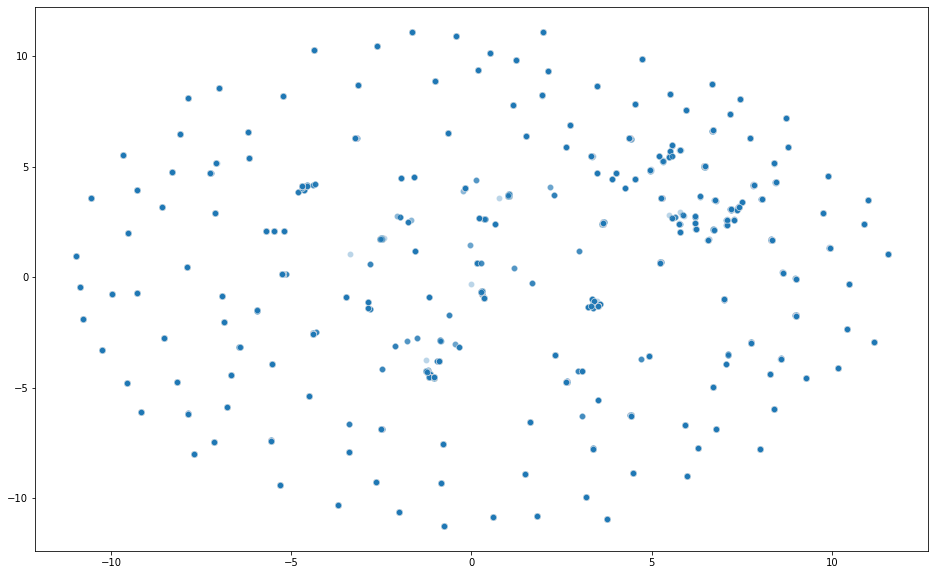

In [136]:

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    alpha=0.3
)

In [52]:
memory_usage(full_df, 'merged_df')

merged_df use 63.90 mb in memory


In [10]:
users = data.groupby('user_id')['row_id'].count().reset_index()

<AxesSubplot:>

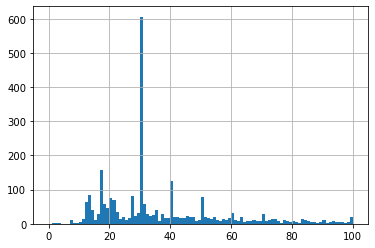

In [14]:
users.row_id.hist(bins=100, range=[0, 100])

In [162]:
full_df[['content_id', 'bundle_id']].drop_duplicates().groupby('content_id')['bundle_id'].count().reset_index().sort_values('bundle_id')

,content_id,bundle_id
13319,32736,0
13166,20474,0
13165,20307,0
13164,20306,0
13163,20105,0
...,...,...
4443,4535,1
4444,4536,1
4445,4537,1
4993,5094,1


In [160]:
full_df[full_df.user_id == 115].sort_values('timestamp')

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,part,tags,type_of_lecture,prior_question_elapsed_time_sum,answers_count,question_elapsed_time
0,0,0,115,5692,0,1,3,1,19933.311111,False,5692.0,5,151,NaN,896999.0,45,37000.0
1,1,56943,115,5716,0,2,2,1,37000.000000,False,5716.0,5,168,NaN,896999.0,45,55000.0
2,2,118363,115,128,0,0,0,1,55000.000000,False,128.0,1,131 149 92,NaN,896999.0,45,19000.0
3,3,131167,115,7860,0,3,0,1,19000.000000,False,7860.0,1,131 104 81,NaN,896999.0,45,11000.0
4,4,137965,115,7922,0,4,1,1,11000.000000,False,7922.0,1,131 149 92,NaN,896999.0,45,5000.0
5,5,157063,115,156,0,5,2,1,5000.000000,False,156.0,1,131 101 162 38,NaN,896999.0,45,17000.0
6,6,176092,115,51,0,6,0,1,17000.000000,False,51.0,1,131 187 81,NaN,896999.0,45,17000.0
7,7,194190,115,50,0,7,3,1,17000.000000,False,50.0,1,131 101 38,NaN,896999.0,45,16000.0
8,8,212463,115,7896,0,8,2,1,16000.000000,False,7896.0,1,131 104 162 81,NaN,896999.0,45,16000.0
9,9,230983,115,7863,0,9,0,1,16000.000000,False,7863.0,1,131 68 92,NaN,896999.0,45,17000.0


In [158]:
data[data.user_id == 115].sort_values('timestamp')

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
5,5,157063,115,156,0,5,2,1,5000.0,False
6,6,176092,115,51,0,6,0,1,17000.0,False
7,7,194190,115,50,0,7,3,1,17000.0,False
8,8,212463,115,7896,0,8,2,1,16000.0,False
9,9,230983,115,7863,0,9,0,1,16000.0,False
